# Statistical Analysis of Data

## Environment Settings

An statistical Analysis of the data captured will be performed.

The environment configuration is the following:

- A rectangle area is used whose dimension is 3 x 3 meters. 
- A custom robot similar to an epuck was used.
- The robot starts in the middle of the arena.
- The robot moves in a random fashion way around the environment avoiding obstacles for 100 robot steps then it is moved into another random location.
- The data is not normalized in this experiment.
- The robot has 8 sensors that measure the distance between the robot and the walls.
- Some noise was introduced in the sensors measurements of the robot using the concept of [lookup tables](https://cyberbotics.com/doc/reference/distancesensor) in the Webots simulator which according to Webots documentation "The first column of the table specifies the input distances, the second column specifies the corresponding desired response values, and the third column indicates the desired standard deviation of the noise. The noise on the return value is computed according to a gaussian random number distribution whose range is calculated as a percent of the response value (two times the standard deviation is often referred to as the signal quality)". The following values were taken:

        - (0, 0, 0.05)
        - (10, 10, 0.05)
        
- The simulator runs during 25 hours of simulation (~30 minutes in fast mode).

In [31]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install keras

import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from keras import optimizers

# First Experiment

In [32]:
csv_file = 'robot_info_dataset.csv'
df = pd.read_csv(csv_file)
df[['x', 'y', 'theta', 'sensor_1', 'sensor_2','sensor_3','sensor_4','sensor_5','sensor_6','sensor_7', 'sensor_8']].head()

,x,y,theta,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8
0,2.661344,0.209868,122.455509,2.636844,0.567515,0.281329,0.327506,0.151153,0.206528,0.664998,0.791497
1,2.661345,0.209866,122.455707,2.811565,0.559246,0.317335,0.337301,0.160830,0.217641,0.650519,0.757750
2,2.660057,0.211891,122.456647,2.888574,0.543504,0.277720,0.323325,0.169616,0.218241,0.609942,0.733189
3,2.658769,0.213916,122.457724,2.598024,0.549208,0.289045,0.329547,0.162631,0.200034,0.630327,0.798025
4,2.657481,0.215941,122.458839,3.016295,0.566460,0.284548,0.328043,0.169804,0.204854,0.692762,0.729235


## Data pre-processing

The data collected 1125965 samples.

In [33]:
df.shape
df = df.sample(frac=1)
df = df[:1125965]
df.shape

(1125965, 15)

The data set contains some null values so they should be deleted from the samples.

In [34]:
df = df.dropna()


## Input and output variables

The data will be split into training, testing and validation sets. 60% of the data will be used for training, 20% for training and 20% of validation.

In [35]:

# train size
test_size_percentage = .2
train_size_percentage = .8
ds_size = df.shape[0]
train_size = int(train_size_percentage * ds_size)
test_size = int(test_size_percentage * ds_size)

# shuffle dataset
sampled_df = df.sample(frac=1)

# separate inputs from outputs
inputs = sampled_df[['x', 'y', 'theta']]
targets = sampled_df[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']]

# train
train_inputs = inputs[:train_size]
train_targets = targets[:train_size]

# test
test_inputs = inputs[train_size:]
test_targets = targets[train_size:]

inputs.head()

,x,y,theta
1487490,1.259873,2.770632,262.826082
1201149,2.554646,0.916666,169.393313
922975,0.194029,0.774991,94.075588
1803448,0.576571,1.352551,179.040511
377954,0.652209,1.898301,94.450072


## Neural Network


As input the neural network receives the x, y coordinates and rotation angle $\theta$. The output are the sensor measurements. One model per sensor will be created.

In [36]:

def get_model():
    # neural network with a 10-neuron hidden layer
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(3,)))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    
#     rmsprop = optimizers.RMSprop(learning_rate=0.01)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
              
    return model

In [37]:
def k_fold(sensor_number, num_epochs=10, k=5):
    num_val_samples = len(train_inputs) // k
    validation_scores = []
    histories = []
    nmse = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_inputs[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[[sensor_number]][i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_inputs[:i * num_val_samples],
             train_inputs[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[[sensor_number]][:i * num_val_samples],
             train_targets[[sensor_number]][(i + 1) * num_val_samples:]], axis=0)


        model = get_model()

        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=64, verbose=1)
        histories.append(history.history)

        predictions_targets = model.predict(val_data)
        nmse.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))
        
    return histories, nmse


In [38]:
histories, nmse = k_fold('sensor_3', 50, 3)

processing fold # 0
Train on 600515 samples, validate on 300257 samples
Epoch 1/50
600515/600515 [==============================] - 16s 27us/step - loss: 0.3274 - mae: 0.3867 - val_loss: 0.1649 - val_mae: 0.2899
Epoch 2/50
600515/600515 [==============================] - 16s 26us/step - loss: 0.1351 - mae: 0.2584 - val_loss: 0.1088 - val_mae: 0.2239
Epoch 3/50
600515/600515 [==============================] - 15s 26us/step - loss: 0.1087 - mae: 0.2233 - val_loss: 0.0873 - val_mae: 0.1953
Epoch 4/50
600515/600515 [==============================] - 16s 26us/step - loss: 0.0966 - mae: 0.2054 - val_loss: 0.2091 - val_mae: 0.3293
Epoch 5/50
600515/600515 [==============================] - 16s 27us/step - loss: 0.0889 - mae: 0.1933 - val_loss: 0.0983 - val_mae: 0.1924
Epoch 6/50
600515/600515 [==============================] - 18s 31us/step - loss: 0.0829 - mae: 0.1839 - val_loss: 0.2489 - val_mae: 0.3609
Epoch 7/50
600515/600515 [==============================] - 18s 31us/step - loss: 0.0785

600515/600515 [==============================] - 17s 29us/step - loss: 0.0805 - mae: 0.1826 - val_loss: 0.1603 - val_mae: 0.2796
Epoch 9/50
600515/600515 [==============================] - 17s 29us/step - loss: 0.0771 - mae: 0.1771 - val_loss: 0.1728 - val_mae: 0.2676
Epoch 10/50
600515/600515 [==============================] - 17s 29us/step - loss: 0.0746 - mae: 0.1724 - val_loss: 0.1269 - val_mae: 0.2268
Epoch 11/50
600515/600515 [==============================] - 17s 29us/step - loss: 0.0726 - mae: 0.1688 - val_loss: 0.0755 - val_mae: 0.1883
Epoch 12/50
600515/600515 [==============================] - 18s 30us/step - loss: 0.0704 - mae: 0.1652 - val_loss: 0.1551 - val_mae: 0.2735
Epoch 13/50
600515/600515 [==============================] - 17s 29us/step - loss: 0.0681 - mae: 0.1613 - val_loss: 0.1945 - val_mae: 0.3138
Epoch 14/50
600515/600515 [==============================] - 17s 29us/step - loss: 0.0661 - mae: 0.1579 - val_loss: 0.0727 - val_mae: 0.1834
Epoch 15/50
600515/600515 

Epoch 16/50
600515/600515 [==============================] - 15s 26us/step - loss: 0.0659 - mae: 0.1560 - val_loss: 0.1351 - val_mae: 0.2493
Epoch 17/50
600515/600515 [==============================] - 16s 26us/step - loss: 0.0646 - mae: 0.1536 - val_loss: 0.0606 - val_mae: 0.1541
Epoch 18/50
600515/600515 [==============================] - 16s 27us/step - loss: 0.0633 - mae: 0.1514 - val_loss: 0.0899 - val_mae: 0.2061
Epoch 19/50
600515/600515 [==============================] - 17s 29us/step - loss: 0.0626 - mae: 0.1503 - val_loss: 0.0582 - val_mae: 0.1458
Epoch 20/50
600515/600515 [==============================] - 17s 28us/step - loss: 0.0620 - mae: 0.1489 - val_loss: 0.1628 - val_mae: 0.2586
Epoch 21/50
600515/600515 [==============================] - 17s 29us/step - loss: 0.0615 - mae: 0.1479 - val_loss: 0.0929 - val_mae: 0.2119
Epoch 22/50
600515/600515 [==============================] - 15s 25us/step - loss: 0.0599 - mae: 0.1456 - val_loss: 0.0694 - val_mae: 0.1548
Epoch 23/50
6

NMSE: 
0.17724597840253278


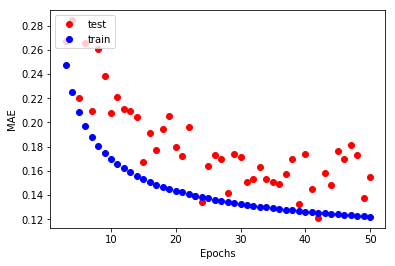

In [39]:
print("NMSE: ")
print(np.mean(nmse))

num_epochs = 50
val_mae_history = [np.mean([x['val_mae'][i] for x in histories]) for i in range(num_epochs)]
mae_history = [np.mean([x['mae'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(3, len(val_mae_history) + 1), val_mae_history[2:], 'ro')
plt.plot(range(3, len(mae_history) + 1), mae_history[2:], 'bo')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['test', 'train'], loc='upper left')
plt.show()


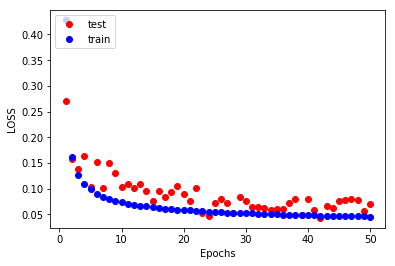

In [40]:
val_loss_history = [np.mean([x['val_loss'][i] for x in histories]) for i in range(num_epochs)]
loss_history = [np.mean([x['loss'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, 'ro')
plt.plot(range(1, len(loss_history) + 1), loss_history, 'bo')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

In [41]:
model = get_model()

history = model.fit(inputs, targets[['sensor_5']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_5.h5")

Epoch 1/50
1125965/1125965 [==============================] - 27s 24us/step - loss: 0.2830 - mae: 0.3892
Epoch 2/50
1125965/1125965 [==============================] - 28s 25us/step - loss: 0.1424 - mae: 0.2614
Epoch 3/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.1053 - mae: 0.2130
Epoch 4/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.0915 - mae: 0.1922
Epoch 5/50
1125965/1125965 [==============================] - 23s 20us/step - loss: 0.0834 - mae: 0.1795
Epoch 6/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.0777 - mae: 0.1706
Epoch 7/50
1125965/1125965 [==============================] - 23s 20us/step - loss: 0.0736 - mae: 0.1639
Epoch 8/50
1125965/1125965 [==============================] - 23s 20us/step - loss: 0.0706 - mae: 0.1590
Epoch 9/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.0684 - mae: 0.1553
Epoch 10/50
1125965/1125965 [==========================

In [42]:
model = get_model()

history = model.fit(inputs, targets[['sensor_6']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_6.h5")

Epoch 1/50
1125965/1125965 [==============================] - 947s 841us/step - loss: 0.2483 - mae: 0.3666
Epoch 2/50
1125965/1125965 [==============================] - 945s 839us/step - loss: 0.1441 - mae: 0.2620
Epoch 3/50
1125965/1125965 [==============================] - 945s 839us/step - loss: 0.1101 - mae: 0.2183
Epoch 4/50
1125965/1125965 [==============================] - 944s 839us/step - loss: 0.0936 - mae: 0.1946
Epoch 5/50
1125965/1125965 [==============================] - 949s 843us/step - loss: 0.0850 - mae: 0.1816
Epoch 6/50
1125965/1125965 [==============================] - 948s 842us/step - loss: 0.0801 - mae: 0.1739
Epoch 7/50
1125965/1125965 [==============================] - 92s 82us/step - loss: 0.0756 - mae: 0.1666
Epoch 8/50
1125965/1125965 [==============================] - 33s 29us/step - loss: 0.0723 - mae: 0.1610
Epoch 9/50
1125965/1125965 [==============================] - 33s 29us/step - loss: 0.0697 - mae: 0.1562
Epoch 10/50
1125965/1125965 [==============

In [43]:
model = get_model()

history = model.fit(inputs, targets[['sensor_7']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_7.h5")

Epoch 1/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.3007 - mae: 0.3737
Epoch 2/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.1503 - mae: 0.2538
Epoch 3/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.1182 - mae: 0.2118
Epoch 4/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.1051 - mae: 0.1925
Epoch 5/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.0974 - mae: 0.1807
Epoch 6/50
1125965/1125965 [==============================] - 23s 21us/step - loss: 0.0932 - mae: 0.1743
Epoch 7/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.0898 - mae: 0.1687
Epoch 8/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.0873 - mae: 0.1646
Epoch 9/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.0847 - mae: 0.1602
Epoch 10/50
1125965/1125965 [==========================

In [44]:
model = get_model()
history = model.fit(inputs, targets[['sensor_8']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_8.h5")

Epoch 1/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.4679 - mae: 0.3930
Epoch 2/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.1992 - mae: 0.2567
Epoch 3/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.1650 - mae: 0.2138
Epoch 4/50
1125965/1125965 [==============================] - 24s 22us/step - loss: 0.1516 - mae: 0.1960
Epoch 5/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.1451 - mae: 0.1869
Epoch 6/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.1403 - mae: 0.1809
Epoch 7/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.1364 - mae: 0.1755
Epoch 8/50
1125965/1125965 [==============================] - 24s 21us/step - loss: 0.1335 - mae: 0.1713
Epoch 9/50
1125965/1125965 [==============================] - 24s 22us/step - loss: 0.1320 - mae: 0.1687
Epoch 10/50
1125965/1125965 [==========================

In [45]:
model = get_model()

history = model.fit(inputs, targets[['sensor_1']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_1.h5")

Epoch 1/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.4452 - mae: 0.3978
Epoch 2/50
1125965/1125965 [==============================] - 24s 22us/step - loss: 0.2191 - mae: 0.2812
Epoch 3/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.1798 - mae: 0.2340
Epoch 4/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.1598 - mae: 0.2087
Epoch 5/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.1500 - mae: 0.1950
Epoch 6/50
1125965/1125965 [==============================] - 24s 22us/step - loss: 0.1451 - mae: 0.1881
Epoch 7/50
1125965/1125965 [==============================] - 24s 22us/step - loss: 0.1419 - mae: 0.1835
Epoch 8/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.1391 - mae: 0.1794
Epoch 9/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.1367 - mae: 0.1758
Epoch 10/50
1125965/1125965 [==========================

In [46]:
model = get_model()

history = model.fit(inputs, targets[['sensor_2']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_2.h5")

Epoch 1/50
1125965/1125965 [==============================] - 25s 23us/step - loss: 0.2626 - mae: 0.3510
Epoch 2/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.1337 - mae: 0.2344
Epoch 3/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.1126 - mae: 0.2029
Epoch 4/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.1025 - mae: 0.1873
Epoch 5/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.0962 - mae: 0.1770
Epoch 6/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.0916 - mae: 0.1694
Epoch 7/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.0886 - mae: 0.1642
Epoch 8/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.0856 - mae: 0.1596
Epoch 9/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.0830 - mae: 0.1555
Epoch 10/50
1125965/1125965 [==========================

In [47]:
model = get_model()

history = model.fit(inputs, targets[['sensor_3']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_3.h5")

Epoch 1/50
1125965/1125965 [==============================] - 25s 22us/step - loss: 0.2559 - mae: 0.3530
Epoch 2/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.1268 - mae: 0.2489
Epoch 3/50
1125965/1125965 [==============================] - 25s 23us/step - loss: 0.0977 - mae: 0.2094
Epoch 4/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.0843 - mae: 0.1896
Epoch 5/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.0765 - mae: 0.1771
Epoch 6/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.0706 - mae: 0.1670
Epoch 7/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.0667 - mae: 0.1596
Epoch 8/50
1125965/1125965 [==============================] - 25s 23us/step - loss: 0.0642 - mae: 0.1553
Epoch 9/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.0628 - mae: 0.1523
Epoch 10/50
1125965/1125965 [==========================

In [48]:
model = get_model()

history = model.fit(inputs, targets[['sensor_4']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_4.h5")

Epoch 1/50
1125965/1125965 [==============================] - 25s 23us/step - loss: 0.3168 - mae: 0.3743
Epoch 2/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.1257 - mae: 0.2427
Epoch 3/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.0994 - mae: 0.2072
Epoch 4/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.0871 - mae: 0.1889
Epoch 5/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.0799 - mae: 0.1777
Epoch 6/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.0756 - mae: 0.1710
Epoch 7/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.0720 - mae: 0.1655
Epoch 8/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.0695 - mae: 0.1617
Epoch 9/50
1125965/1125965 [==============================] - 26s 23us/step - loss: 0.0678 - mae: 0.1588
Epoch 10/50
1125965/1125965 [==========================